## CS 5963 Project Milestone

# New York City Schools Survey

## **Group Members**  

Kara Johnson (u0409733) - E-mail: kjohnson@sci.utah.edu   
Sara Johnson (u0884127) - E-mail: sara.l.johnson@utah.edu

### Background and Motivation (EDIT THIS)

Education is an important pillar in our society today. Many parents in America feel dissatisfied with the public school system. The goal of this project is to identify some factors which may contribute parent perceptions of their child's school. We will be using New York City as a model, as it has over 400 high schools and has made data from their annual school survey available for analysis. This survey collects responses to a number of questions pertaining to many aspects of education, but we are focusing on trust & family ties, safety, and personal attention & support as indicators of overall parent perception. We will investigate if parent perception of these aspects differ as a function of the school's location or educational opportunities such as AP courses or Career Training courses. By generating this predictive model, we can determine how to improve parent perceptions of schools in the future.

### Project Objectives (EDIT THIS)

**Objective 1.** We will be looking at the positive response rates that pertain to three "Educational Elements": Parent trust in the school, parent involvement, and parent response rate
    - How do these elements relate to each other?
    - How do these elements relate to the opportunities available at these schools (extracurriculars, AP classes, CTE)? 
    - How do these elements differ between boroughs and/or districts?   
**Objective 2.** We are interested in looking at student perception of school safety a possible confounder in parent perceptions.

**Objective 3.** Finally, we will determine which factors could potentially improve parent perceptions of our education system 
    - These factors include AP and Career training availability, attendance rate, graduation rate, and percentage of positive student answers 


### Data

We collected and combined three datasets: 
1. 2016 New York City School Survey -- collects student and parent responses to surveys about their school,   
2. High Schools At A Glance -- includes information about high school programs, Advanced Placement (AP) courses, and career training programs,   
3. Demographic Snapshot -- demographic information including total enrollment, gender ratios, and race percentages at the city, borough, district, and school-level.   

These datasets are available online in Excel spreadsheet format.

2016 New York City School Survey: http://schools.nyc.gov/Accountability/tools/survey/default.htm   
High Schools At a Glance: http://schools.nyc.gov/ChoicesEnrollment/High/Resources/default.htm
Demographic Snapshot: http://schools.nyc.gov/NR/rdonlyres/46093164-D8AA-40DD-A400-8F80CEBC8DD5/0/DemographicSnapshot201112to201516Public_FINAL.xlsx

### Data Processing

For the survey dataset, we selected a number of variables that we were interested in. These include:
- Parent response rate
- % Satisfaction with 'Collaborative Teachers'
- % Satisfaction with 'School Leadership'
- % Satisfaction with 'Rigorous Instruction'
- % Satisfaction with 'Family-Community Ties'
- % Satisfaction with 'Supportive Environment'
- % Satisfaction with 'Trust'
- % Overall Parent Satisfaction
- % Overall Student Satisfaction

We also removed all schools that do not correlate with the "High School At a Glance" dataset. This was performed by matching the school's unique DBN number provided in both datasets.   

We also extracted other variables from the "High School At a Glance" dataset that we will use for performing our analysis. These include:
- Borough
- Number of Programs
- Neighborhood
- Graduation Rate 
- Attendance Rate
- % Students who feel safe
- AP Courses 
- CTE Programs

AP Courses and CTE Programs categories were converted into a binary value: 1 for offered, 0 for not offered.    

For the Demographics dataset, we extracted the following columns at the citywide, borough, district, and school-level:   
- Total enrollment
- % Female, % Male
- % Asian, Black, Hispanic, Other, or White
- % Poverty

We also had to filter out the rows to extract only the data from the 2015-2016 school year.

In [534]:
import pandas as pd

#NYC School Survery Import (HSS): 
RespRate = pd.read_excel("2016 NYC School Survey Public Data.xlsx",sheetname = 0)

#High Schools At a Glance Import (HSAAG): 
schools = pd.read_csv('HSAAG_data/HSAAG_Schools.csv', encoding='latin-1',header=0)

#Demographics:
dem_school = pd.read_excel("DemographicSnapshot201112to201516Public_FINAL.xlsx",sheetname=3)



In [609]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,10)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])

 
# HSAAG - Keep columns of interest
schools = pd.read_csv('HSAAG_data/HSAAG_Schools.csv', encoding='latin-1',header=0)
schools.columns = ['rmv','School Name', 'DBN','Borough','Number of Programs','rmv2','rmv3', 'Neighborhood',
                   'Graduation Rate','Attendance Rate', '% students who feel safe','AP Courses y/n',
                   'rmv7', 'CTE y/n','rmv4', 'rmv5', 'rmv6']
school_cols = ['DBN', 'Borough', 'Number of Programs','Neighborhood', 'Graduation Rate', 
               'Attendance Rate','% students who feel safe', 'AP Courses y/n','CTE y/n']

schoolsDF = schools[school_cols]

# HSAAG - Change 'Graduation Rate', 'Attendance Rate', and '% students who feel safe' to decimals

schoolsDF['Graduation Rate'] = schoolsDF['Graduation Rate'].str.replace('%','').astype(float).apply(lambda x: x/100);
schoolsDF['Attendance Rate'] = schoolsDF['Attendance Rate'].str.replace('%','').astype(float).apply(lambda x: x/100);
schoolsDF['% students who feel safe'] = schoolsDF['% students who feel safe'].str.replace('%','').astype(float).apply(lambda x: x/100);

# HSAAG - Change Yes to 1. NaNs in this dataset correspond to 'No', so set NaNs to 0
# Index to DBN for easy comparison and merging of dataframes
schoolsDF = schoolsDF.fillna(0).replace('Yes',1).set_index('DBN')

# HSS - Keep columns of interest
RespRate.columns = ['DBN','School Name', 'Parent RR','Teacher RR','Student RR','Collab. Teachers','School Leadership',
                   'Rig. Instruction','Fam-Community Ties', 'Supportive Envment.','Trust','Parent PS',
                   'Student PS', 'Teacher PS']
RespRate_cols = ['DBN','Parent RR','Collab. Teachers','School Leadership','Rig. Instruction','Fam-Community Ties', 
                 'Supportive Envment.','Trust','Parent PS','Student PS']
schools2 = RespRate[RespRate_cols]

# Demographics - Keep columns of interest
dem_school_cols = ['DBN','Year', 'Total Enrollment','% Female','% Male','% Asian', '% Black', '% Hispanic','% Other',
                   '% White','% Students with Disabilities', '% Poverty']
demog = dem_school[dem_school_cols]

# Demographics - keep data from 2015-2016 school year
demo_rec = demog[demog['Year'] == '2015-16']
demog_cols = ['DBN','Total Enrollment','% Female','% Male','% Asian', '% Black', '% Hispanic','% Other',
                   '% White','% Students with Disabilities', '% Poverty']
demog = demo_rec[demog_cols]
minorities = ['% Asian','% Black','% Hispanic','% Other']
demog['% Minority'] = demog[minorities].sum(axis=1)
demog_cols2 = ['DBN','Total Enrollment','% Female','% Male','% White','% Minority','% Poverty']
demog2 = demog[demog_cols2]

# Combine HSAAG and HSS by joining with School DBN as index 
schools_HS = schoolsDF.join(schools2.set_index('DBN'),how = 'inner')
schoolsN = schools_HS.join(demog2.set_index('DBN'), how = 'inner')

# Convert all non-strings to floats for easier processing 
schoolsN = schoolsN.apply(lambda x: pd.to_numeric(x,errors='ignore')).fillna(0)
schoolsN.columns = ['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate', 'AttendanceRate', 
         'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR', 'Collab_Teachers', 'School_Leadership',
         'Rig_Instruction', 'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS', 
         'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale','PerWhite', 'PerMinority','PerPoverty']
schoolsN['ParentStudentPS_Diff'] = schoolsN['ParentPS'] - schoolsN['StudentPS'] 

cols3 = [0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
results = schoolsN[cols3].corr()
schoolsN.columns

/Users/karajohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/karajohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/karajohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Index(['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate',
       'AttendanceRate', 'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR',
       'Collab_Teachers', 'School_Leadership', 'Rig_Instruction',
       'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS',
       'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale', 'PerWhite',
       'PerMinority', 'PerPoverty', 'ParentStudentPS_Diff'],
      dtype='object')

### Exploratory Data Analysis (EDIT THIS)

First, using our combined dataframe, we generated a correlation matrix and scatter matrix to identify any promising correlations. We also calculated descriptive statistics of the variables to (1) make sure that the values are reasonable and (2) identify any interesting attributes. We also generated some preliminary cluster plots and heat maps to look at interesting relationships of variables with borough and/or neighborhood.

#### 1. Correlation Matrix of Dataframe Columns

In [606]:
#results = results.where(abs(results) > .4)

Var1 = []
Var2 = []
Correlation = []
#print(schoolsN[cols3].corr())
#results.columns.tolist()
for index,row in results.iterrows(): 
    for col in results.columns.tolist():
        if (abs(results.loc[index,col]) >= .2) & (abs(results.loc[index,col]) < .4): 
            Var1.append(index)
            Var2.append(col)
            Correlation.append(results.loc[index,col])
            
LowCor = pd.DataFrame({'Var1':Var1,'Var2':Var2,'Correlation':Correlation})
LowCor = LowCor[['Var1','Var2','Correlation']] 
print('Variables with Low Correlation: ')
LowCor2 = LowCor[(LowCor['Var1'] == 'ParentRR') | (LowCor['Var1'] == 'ParentPS') | 
                 (LowCor['Var1'] == 'StudentPS') | (LowCor['Var1'] == 'ParentStudentPS_Diff')]
print(LowCor2)

Var1 = []
Var2 = []
Correlation = []
#print(schoolsN[cols3].corr())
#results.columns.tolist()
for index,row in results.iterrows(): 
    for col in results.columns.tolist():
        if (abs(results.loc[index,col]) >= .4) & (abs(results.loc[index,col]) < .6): 
            Var1.append(index)
            Var2.append(col)
            Correlation.append(results.loc[index,col])
            
MedCor = pd.DataFrame({'Var1':Var1,'Var2':Var2,'Correlation':Correlation})
MedCor = MedCor[['Var1','Var2','Correlation']] 
print('Variables with Medium Correlation: ')
MedCor2 = MedCor[(MedCor['Var1'] == 'ParentRR') | (MedCor['Var1'] == 'ParentPS') | 
                 (MedCor['Var1'] == 'StudentPS') | (MedCor['Var1'] == 'ParentStudentPS_Diff')]
print(MedCor2)

Var1 = []
Var2 = []
Correlation = []
for index,row in results.iterrows(): 
    for col in results.columns.tolist():
        if (abs(results.loc[index,col]) >= .6) & (abs(results.loc[index,col]) < 1): 
            Var1.append(index)
            Var2.append(col)
            Correlation.append(results.loc[index,col])
            
HighCor = pd.DataFrame({'Var1':Var1,'Var2':Var2,'Correlation':Correlation})
HighCor = HighCor[['Var1','Var2','Correlation']] 
print('Variables with High Correlation: ')
HighCor2 = HighCor[(HighCor['Var1'] == 'ParentRR') | (HighCor['Var1'] == 'ParentPS') 
                   | (HighCor['Var1'] == 'StudentPS') | (HighCor['Var1'] == 'ParentStudentPS_Diff')]
print(HighCor2)

Variables with Low Correlation: 
         Var1                Var2  Correlation
31   ParentRR      AttendanceRate     0.200776
32   ParentRR     PerStudentsSafe     0.266091
33   ParentRR     Collab_Teachers     0.302886
34   ParentRR   School_Leadership     0.284814
35   ParentRR     Rig_Instruction     0.324805
36   ParentRR   FamCommunity_Ties     0.379992
37   ParentRR               Trust     0.298033
38   ParentRR            ParentPS     0.279462
64   ParentPS            ParentRR     0.279462
65   ParentPS     Collab_Teachers     0.268530
66   ParentPS   School_Leadership     0.343284
67   ParentPS     Rig_Instruction     0.295701
68   ParentPS  Supportive_Envment     0.335781
69   ParentPS           StudentPS     0.322193
70  StudentPS      AttendanceRate     0.295525
71  StudentPS            ParentPS     0.322193
Variables with Medium Correlation: 
         Var1                Var2  Correlation
4    ParentRR  Supportive_Envment     0.464741
5    ParentRR           StudentPS     

### Analysis

#### 1. Multilinear Regression of Factors Important to Students or Parents

In [613]:
import scipy as sc
from scipy.stats import linregress
from scipy.stats import norm

import statsmodels.formula.api as sm

# Parents:
model = sm.ols(formula="ParentPS ~ School_Leadership + Trust + FamCommunity_Ties",
               data=schoolsN)
model_result = model.fit()
print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
print('P-values: \n' + str(model_result.pvalues) + '\n')

schoolsN['NeighNum'] = pd.Categorical(schoolsN["Neighborhood"]).labels


ParentPS ~ School_Leadership + Trust + FamCommunity_Ties R-squared: 0.356849335202
P-values: 
Intercept            9.133277e-02
School_Leadership    3.900077e-03
Trust                2.859016e-06
FamCommunity_Ties    5.967533e-23
dtype: float64



/Users/karajohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: 'labels' is deprecated. Use 'codes' instead


In [611]:
# Students:
model = sm.ols(formula="StudentPS ~ Trust + Collab_Teachers + Supportive_Envment", data=schoolsN)
model_result = model.fit()
print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
print('P-values: \n' + str(model_result.pvalues) + '\n')

StudentPS ~ Trust + Collab_Teachers + Supportive_Envment R-squared: 0.975938072793
P-values: 
Intercept              7.880556e-16
Trust                  7.642619e-12
Collab_Teachers        2.391129e-44
Supportive_Envment    1.725314e-310
dtype: float64



### Classification with Important Factors to Parents

#### 1. Classification of Percent Poverty

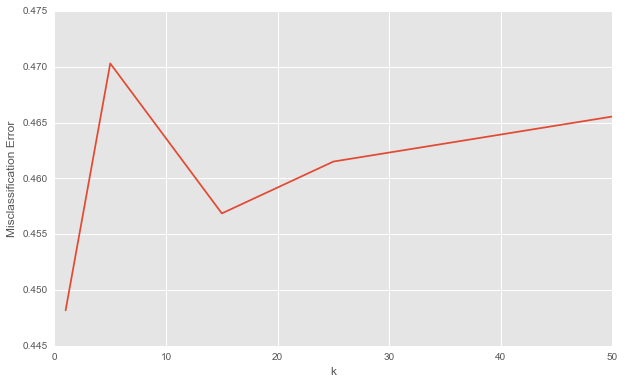

Accuracy on training data =  0.634703196347
Accuracy on test data =  0.493150684932


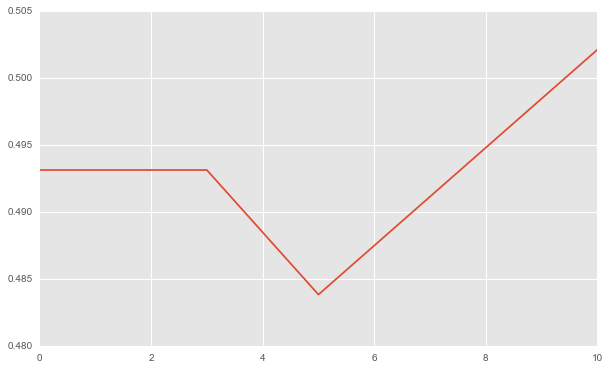

Accuracy on training data=  0.506849315068
Accuracy on test data=  0.493150684932


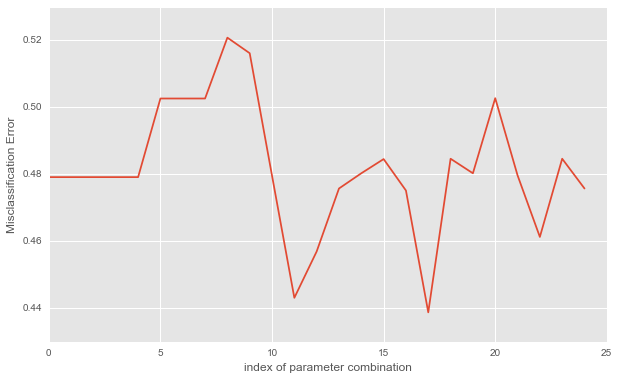

[17]
Accuracy on training data=  0.694063926941
Accuracy on test data=  0.48401826484


In [622]:
from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split, cross_val_predict, cross_val_score, KFold

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')


schoolsN['Borough_bool'] = schoolsN['Borough'].map({'M':0, 'BX':1, 'BK':2, 'Q':3, 'SI':4})

# Define predictor variables 
pred_cols = [10,12,14] # School 
#['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate',
#       'AttendanceRate', 'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR',
#       'Collab_Teachers', 'School_Leadership', 'Rig_Instruction',
#       'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS',
#       'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale', 'PerWhite',
#       'PerMinority', 'PerPoverty', 'ParentStudentPS_Diff']

pred_vars = schoolsN[pred_cols].as_matrix()

class_var = schoolsN['PerPoverty'].as_matrix()
medclass = np.median(class_var)
class_var_bool = class_var > medclass

class_Bool = class_var_bool.astype(int)

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)

# 1. K-NN
neighbors = [1, 5, 15, 25, 50]
scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv = cross_val_score(knn, predTrain, classTrain, cv=5, scoring='accuracy')
    scores.append(cv.mean())

error = [1 - s for s in scores]
bestK = neighbors[error.index(min(error))]
plt.plot(neighbors, error)
plt.xlabel('k')
plt.ylabel('Misclassification Error')
plt.show()

k = 15
test = KNeighborsClassifier(n_neighbors=k)
test.fit(predTrain, classTrain)

test_y_pred = test.predict(predTest)
train_y_pred = test.predict(predTrain)

print('Accuracy on training data = ', metrics.accuracy_score(y_true = classTrain, y_pred = train_y_pred))
print('Accuracy on test data = ', metrics.accuracy_score(y_true = classTest, y_pred = test_y_pred))

# 2. SVM

# Cross-validation to choose C
c = [0.01, 0.1, 1, 3, 5, 10]
Cscores = []
for i in c: 
    svm_model = svm.SVC(kernel='rbf', C = i)
    SVMscores = cross_val_score(svm_model, predTrain, classTrain, cv=5, scoring='accuracy')    
    Cscores.append(SVMscores.mean())
        
CError = [1 - t for t in Cscores]

bestC = [CError.index(min(CError))]

plt.plot(c,CError)
plt.show()

# Run and fit the model on the full data
svmX = svm.SVC(kernel='rbf',C=5)
svmX.fit(predTrain, classTrain)

y_train = svmX.predict(predTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = classTrain, y_pred = y_train))

y_test = svmX.predict(predTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = classTest, y_pred = y_test))


# 3. Decision Tree
# Cross-validation to choose max tree depth and minimum samples split
depths = [1, 5,10,25,50]
minSamples = [1, 5, 10, 30, 50]
treeScores = []

for d in depths:
    for minsamp in minSamples:
        decTree = tree.DecisionTreeClassifier(max_depth=d, min_samples_split=minsamp)
        cvs = cross_val_score(decTree, predTrain, classTrain, cv=5, scoring='accuracy')
        treeScores.append(cvs.mean())

treeError = [1 - x for x in treeScores]

bestParam = [treeError.index(min(treeError))]

plt.plot(list(range(len(treeError))), treeError)
plt.xlabel('index of parameter combination')
plt.ylabel('Misclassification Error')
plt.show()
print(bestParam)

decisionTree = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=5)
decisionTree = decisionTree.fit(predTrain, classTrain)

y_pred_train = decisionTree.predict(predTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = classTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(predTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = classTest, y_pred = y_pred))


From these results, the best classification method appears to be the Decision Tree method. We decided to use this method for the remaining classifications for direct comparisons.

#### 2. Classification of Borough

/Users/karajohnson/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Users/karajohnson/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Users/karajohnson/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Users/karajohnson/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, wh

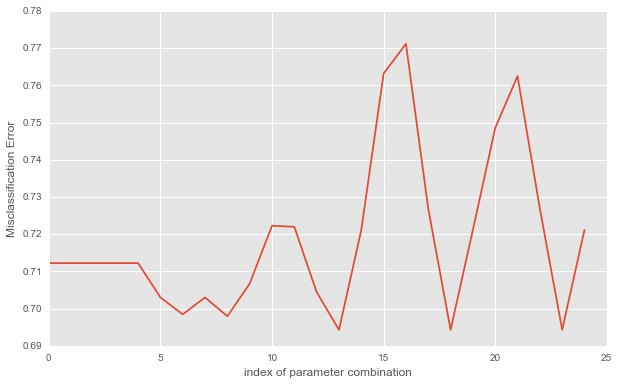

[13]
Accuracy on training data=  0.429223744292
Accuracy on test data=  0.223744292237


In [626]:
# Define predictor variables 
pred_cols = [10,12,14] # School 
#['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate',
#       'AttendanceRate', 'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR',
#       'Collab_Teachers', 'School_Leadership', 'Rig_Instruction',
#       'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS',
#       'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale', 'PerWhite',
#       'PerMinority', 'PerPoverty', 'ParentStudentPS_Diff']

pred_vars = schoolsN[pred_cols].as_matrix()

class_var = schoolsN['Borough_bool'].as_matrix()
class_Bool = class_var.astype(int)

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)

# 3. Decision Tree
# Cross-validation to choose max tree depth and minimum samples split
depths = [1, 5,10,25,50]
minSamples = [1, 5, 10, 30, 50]
treeScores = []

for d in depths:
    for minsamp in minSamples:
        decTree = tree.DecisionTreeClassifier(max_depth=d, min_samples_split=minsamp)
        cvs = cross_val_score(decTree, predTrain, classTrain, cv=5, scoring='accuracy')
        treeScores.append(cvs.mean())

treeError = [1 - x for x in treeScores]

bestParam = [treeError.index(min(treeError))]

plt.plot(list(range(len(treeError))), treeError)
plt.xlabel('index of parameter combination')
plt.ylabel('Misclassification Error')
plt.show()
print(bestParam)

decisionTree = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=30)
decisionTree = decisionTree.fit(predTrain, classTrain)

y_pred_train = decisionTree.predict(predTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = classTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(predTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = classTest, y_pred = y_pred))


#### Classification of Percent Minority

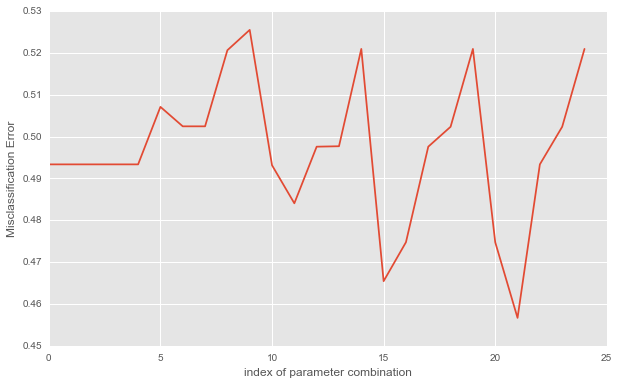

[21]
Accuracy on training data=  0.566210045662
Accuracy on test data=  0.51598173516


In [629]:
# Define predictor variables 
pred_cols = [10,12,14] # School 
#['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate',
#       'AttendanceRate', 'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR',
#       'Collab_Teachers', 'School_Leadership', 'Rig_Instruction',
#       'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS',
#       'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale', 'PerWhite',
#       'PerMinority', 'PerPoverty', 'ParentStudentPS_Diff']

pred_vars = schoolsN[pred_cols].as_matrix()

class_var = schoolsN['PerMinority'].as_matrix()
medclass = np.median(class_var)
class_var_bool = class_var > medclass

class_Bool = class_var_bool.astype(int)

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)

# 3. Decision Tree
# Cross-validation to choose max tree depth and minimum samples split
depths = [1, 5,10,25,50]
minSamples = [1, 5, 10, 30, 50]
treeScores = []

for d in depths:
    for minsamp in minSamples:
        decTree = tree.DecisionTreeClassifier(max_depth=d, min_samples_split=minsamp)
        cvs = cross_val_score(decTree, predTrain, classTrain, cv=5, scoring='accuracy')
        treeScores.append(cvs.mean())

treeError = [1 - x for x in treeScores]

bestParam = [treeError.index(min(treeError))]

plt.plot(list(range(len(treeError))), treeError)
plt.xlabel('index of parameter combination')
plt.ylabel('Misclassification Error')
plt.show()
print(bestParam)

decisionTree = tree.DecisionTreeClassifier(max_depth=1, min_samples_split=50)
decisionTree = decisionTree.fit(predTrain, classTrain)

y_pred_train = decisionTree.predict(predTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = classTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(predTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = classTest, y_pred = y_pred))


### Classification Using Important Factors to Students

#### 1. Classification of Percent Poverty

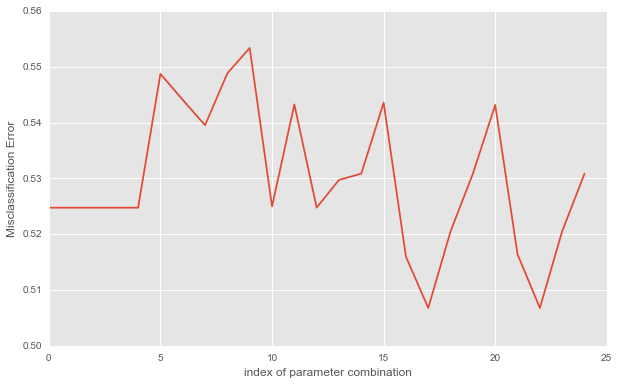

[17]
Accuracy on training data=  0.547945205479
Accuracy on test data=  0.470319634703


In [636]:
# Define predictor variables 
pred_cols = [9,13,14] # School 
#['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate',
#       'AttendanceRate', 'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR',
#       'Collab_Teachers', 'School_Leadership', 'Rig_Instruction',
#       'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS',
#       'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale', 'PerWhite',
#       'PerMinority', 'PerPoverty', 'ParentStudentPS_Diff']

pred_vars = schoolsN[pred_cols].as_matrix()

class_var = schoolsN['PerPoverty'].as_matrix()
medclass = np.median(class_var)
class_var_bool = class_var > medclass

class_Bool = class_var_bool.astype(int)

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)

# Decision Tree
# Cross-validation to choose max tree depth and minimum samples split
depths = [1, 5,10,25,50]
minSamples = [1, 5, 10, 30, 50]
treeScores = []

for d in depths:
    for minsamp in minSamples:
        decTree = tree.DecisionTreeClassifier(max_depth=d, min_samples_split=minsamp)
        cvs = cross_val_score(decTree, predTrain, classTrain, cv=5, scoring='accuracy')
        treeScores.append(cvs.mean())

treeError = [1 - x for x in treeScores]

bestParam = [treeError.index(min(treeError))]

plt.plot(list(range(len(treeError))), treeError)
plt.xlabel('index of parameter combination')
plt.ylabel('Misclassification Error')
plt.show()
print(bestParam)

decisionTree = tree.DecisionTreeClassifier(max_depth=1, min_samples_split=50)
decisionTree = decisionTree.fit(predTrain, classTrain)

y_pred_train = decisionTree.predict(predTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = classTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(predTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = classTest, y_pred = y_pred))


#### 2. Classification of Borough

/Users/karajohnson/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Users/karajohnson/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Users/karajohnson/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Users/karajohnson/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, wh

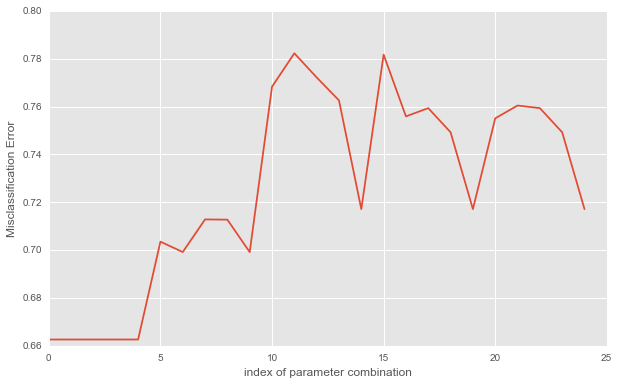

[0]
Accuracy on training data=  0.34703196347
Accuracy on test data=  0.269406392694


In [635]:
# Define predictor variables 
pred_cols = [9,13,14] # School 
#['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate',
#       'AttendanceRate', 'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR',
#       'Collab_Teachers', 'School_Leadership', 'Rig_Instruction',
#       'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS',
#       'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale', 'PerWhite',
#       'PerMinority', 'PerPoverty', 'ParentStudentPS_Diff']

pred_vars = schoolsN[pred_cols].as_matrix()

class_var = schoolsN['Borough_bool'].as_matrix()

class_Bool = class_var.astype(int)

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)

# Decision Tree
# Cross-validation to choose max tree depth and minimum samples split
depths = [1, 5,10,25,50]
minSamples = [1, 5, 10, 30, 50]
treeScores = []

for d in depths:
    for minsamp in minSamples:
        decTree = tree.DecisionTreeClassifier(max_depth=d, min_samples_split=minsamp)
        cvs = cross_val_score(decTree, predTrain, classTrain, cv=5, scoring='accuracy')
        treeScores.append(cvs.mean())

treeError = [1 - x for x in treeScores]

bestParam = [treeError.index(min(treeError))]

plt.plot(list(range(len(treeError))), treeError)
plt.xlabel('index of parameter combination')
plt.ylabel('Misclassification Error')
plt.show()
print(bestParam)

decisionTree = tree.DecisionTreeClassifier(max_depth=1, min_samples_split=50)
decisionTree = decisionTree.fit(predTrain, classTrain)

y_pred_train = decisionTree.predict(predTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = classTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(predTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = classTest, y_pred = y_pred))

#### 3. Classification of Percent Minority

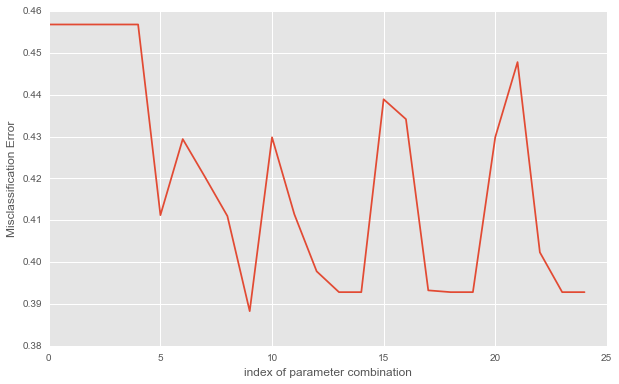

[9]
Accuracy on training data=  0.616438356164
Accuracy on test data=  0.534246575342


In [634]:
# Define predictor variables 
pred_cols = [9,13,14] # School 
#['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate',
#       'AttendanceRate', 'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR',
#       'Collab_Teachers', 'School_Leadership', 'Rig_Instruction',
#       'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS',
#       'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale', 'PerWhite',
#       'PerMinority', 'PerPoverty', 'ParentStudentPS_Diff']

pred_vars = schoolsN[pred_cols].as_matrix()

class_var = schoolsN['PerMinority'].as_matrix()
medclass = np.median(class_var)
class_var_bool = class_var > medclass

class_Bool = class_var_bool.astype(int)

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)

# Decision Tree
# Cross-validation to choose max tree depth and minimum samples split
depths = [1, 5,10,25,50]
minSamples = [1, 5, 10, 30, 50]
treeScores = []

for d in depths:
    for minsamp in minSamples:
        decTree = tree.DecisionTreeClassifier(max_depth=d, min_samples_split=minsamp)
        cvs = cross_val_score(decTree, predTrain, classTrain, cv=5, scoring='accuracy')
        treeScores.append(cvs.mean())

treeError = [1 - x for x in treeScores]

bestParam = [treeError.index(min(treeError))]

plt.plot(list(range(len(treeError))), treeError)
plt.xlabel('index of parameter combination')
plt.ylabel('Misclassification Error')
plt.show()
print(bestParam)

decisionTree = tree.DecisionTreeClassifier(max_depth=1, min_samples_split=50)
decisionTree = decisionTree.fit(predTrain, classTrain)

y_pred_train = decisionTree.predict(predTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = classTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(predTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = classTest, y_pred = y_pred))

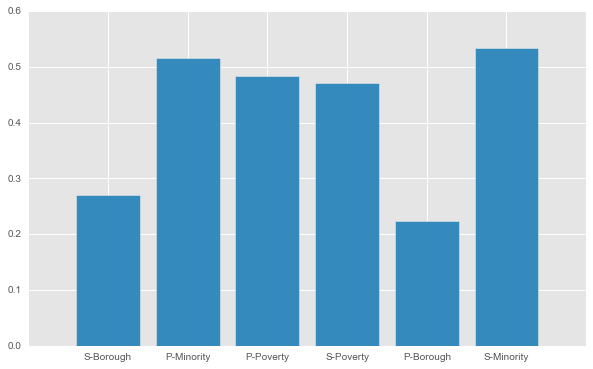

In [646]:
stud_pov = 0.470319634703
stud_bor = 0.269406392694
stud_min = 0.534246575342

par_pov = 0.48401826484
par_bor = 0.223744292237
par_min = 0.51598173516

totals = [stud_pov,par_pov,stud_bor,par_bor,stud_min,par_min]
labels = [0,1,2,3,4,5]

d = {'S-Poverty':stud_pov, 'P-Poverty':par_pov, 'S-Borough':stud_bor,'P-Borough':par_bor,'S-Minority':stud_min,'P-Minority':par_min}

plt.bar(range(len(d)), d.values(), align='center');
plt.xticks(range(len(d)), d.keys());


